In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10'

In [2]:
import numpy as np
import jax
import treams.special as ts
import treams

In [3]:
x = y = np.linspace(-500, 500, 121)
X, Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
Z = np.zeros_like(X)
pos = np.array([
  [-350, 350, -300, 300, -300, 300],
  [0,    0,   -165, -165, 165, 165],
  [0,    0,   0,    0,    0,   0]
]).T

In [4]:
k0 = 0.011180689785085548-0.0004307384124945234j
basis = treams.CylindricalWaveBasis.default(0, 3, 6, positions=pos)
basis = basis[basis.pol==0]
material = treams.Material(1)

In [5]:
ks = material.ks(k0)[basis.pol]
krhos = material.krhos(k0, basis.kz, basis.pol) *(1-0.2j)

In [6]:
%%timeit 
rcyl = ts.car2cyl(np.array([X,Y,Z]).T[:, np.newaxis] - basis.positions)

9.67 ms ± 145 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
rcyl = ts.car2cyl(np.array([X,Y,Z]).T[:, np.newaxis] - basis.positions)

In [8]:
rcyl[..., basis.pidx, 0].shape

(14641, 42)

In [9]:
42*14641

614922

In [10]:
from scipy.special import hankel1

In [11]:
x = np.linspace(1, 1000, 90000)

In [12]:
%timeit hankel1(1, x)

21.3 ms ± 836 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%timeit np.exp(x)

<magic-timeit>:1: RuntimeWarning: overflow encountered in exp


674 μs ± 4.12 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
from importlib import reload
import treams.jcyl._tmatrixc as jat
jat = reload(jat)

In [15]:
x = np.linspace(0, 100, 30)
positions = np.array([x,np.zeros_like(x),np.zeros_like(x)])
radius = 1

epsilons = [4, 1]
k0s = np.array([1+0j]*10) #, 2+0j

jat.globalt(2, [0], k0s, radius, positions, epsilons, None)
%timeit  jat.globalt(2, [0], k0s, radius, positions, epsilons, None)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


920 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
mmax = 2
kzs = [0]

num = positions.shape[1]
size = num*(1+2*mmax)*2

%timeit tlocal = jat.localt(mmax, kzs, k0s, radius, num, epsilons)
tlocal = jat.localt(mmax, kzs, k0s, radius, num, epsilons)

environment = treams.Material(epsilons[-1])
%timeit jat.globfromloc(tlocal, positions, mmax, kzs, k0s, num, environment, None)

56.2 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
929 ms ± 7.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
tlocal = jat.localt(mmax, kzs, k0s, radius, num, epsilons)
tlocal = tlocal[0]

In [18]:
modes = jat.defaultmodes(mmax, kzs, num)
pidx, kz, m, pol = modes
pos = np.array(positions).T
ind = pos[:, None, :] - pos
rho, theta, phi = np.array(jat.cw.car2cyl(*ind.T))[:, pidx[:, None], pidx]

krho = jat.krhos(k0, kz, pol, material) #TODO diffable

translation = jat.cw.translate(
    *modes[1:, :, None], #kz, m, pol
    *modes[1:],
    krho*rho,
    theta,
    phi,
)
%timeit jat.cw.translate(*modes[1:, :, None],*modes[1:],krho*rho,theta,phi)

translation = np.where(rho != 0, translation, 0)

B = tlocal @ np.reshape(translation, tlocal.shape)
A = np.eye(tlocal.shape[0]) - B

finalt = np.linalg.solve(
    A,
    tlocal,
)

%timeit np.linalg.solve(A,tlocal)

61.1 ms ± 208 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 7.08 times longer than the fastest. This could mean that an intermediate result is being cached.
15.7 ms ± 9.81 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
pz, pm, pol = modes[1:, :, None]
qz, qm, qol = modes[1:]

In [20]:
(pm-qm).shape

(300, 300)

In [21]:
300*300

90000

In [22]:
(krho*rho).shape

(300, 300)

In [23]:
%timeit hankel1(pm-qm, krho*rho)

46.8 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
import treams.jspecial as jts
jts = reload(jts)

In [25]:
mask = np.logical_and(pol==qol, pz == qz)
%timeit jts.hankel1(pm-qm, krho*rho, mask)

39.3 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
mask.shape

(300, 300)

In [27]:
np.sum(mask)

45000

In [28]:
300*300

90000

In [50]:
import baryrat
import jax.numpy as np
import scipy.special
import matplotlib.pyplot as plt
import jax

def inv_bessel(z):
    return 1/scipy.special.jn(1, z)

def bessel(z):
    return scipy.special.jn(1, z)

z_r = np.linspace(0, 10, 50)
z_i = np.linspace(-1, 1, 50)
Z_r, Z_i = np.meshgrid(z_r, z_i)
Z = Z_r +1j*Z_i
F = bessel(Z)
r = baryrat.aaa(Z, F, mmax=13)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


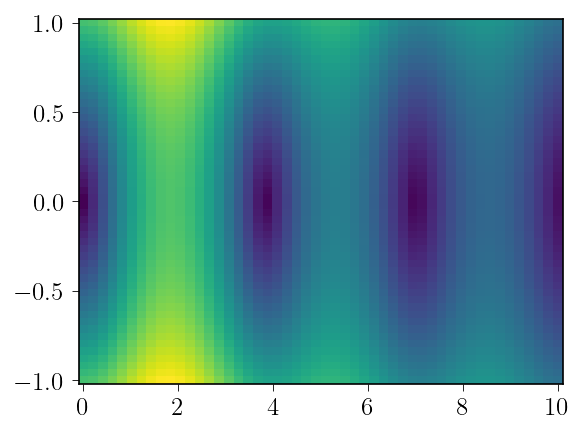

In [52]:
plt.pcolormesh(Z_r, Z_i, np.abs(F))

In [85]:
z_r_time = np.linspace(0.1, 9.9, 6000)
z_i_time = np.linspace(-1, 1, 6000)
Z_r_time, Z_i_time = np.meshgrid(z_r_time, z_i_time)
Z_time = Z_r_time +1j*Z_i_time
%timeit r(Z_time)

6.13 s ± 353 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%timeit bessel(Z_time)

22 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
@jax.jit
def eval_baryrat(zj, wj, fj, x):
    xv = x.ravel()
    D = xv[:,None] - zj[None,:]

    C = np.divide(1, D)
    r = C.dot(wj * fj) / C.dot(wj)
    
    return r.reshape(x.shape)

In [88]:
@jax.jit
def eval_baryrat(zj, wj, fj, x):
    #xv = x.ravel()
    D = x[:,None] - zj[None,:]
    C = 1/D
    r = C.dot(wj * fj) / C.dot(wj)
    return r
    #return r.reshape(x.shape)

In [89]:
eval_baryrat(r.nodes, r.weights, r.values, Z_time.ravel())

Array([0.07000022-0.56301343j, 0.07114074-0.56294286j,
       0.07228106-0.5628712j , ..., 0.09171253-0.29018947j,
       0.09109121-0.2902652j , 0.09046902-0.29034024j], dtype=complex64)

In [90]:
flat = Z_time.ravel()
%timeit eval_baryrat(r.nodes, r.weights, r.values, flat)

2.66 s ± 69.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


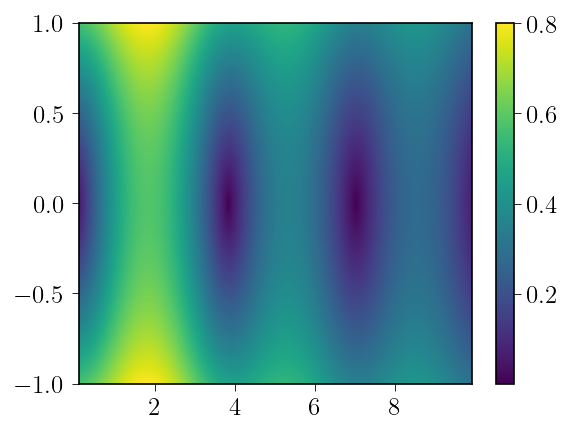

In [73]:
plt.pcolormesh(Z_r_time, Z_i_time, np.abs(eval_baryrat(r.nodes, r.weights, r.values, Z_time)))
plt.colorbar()

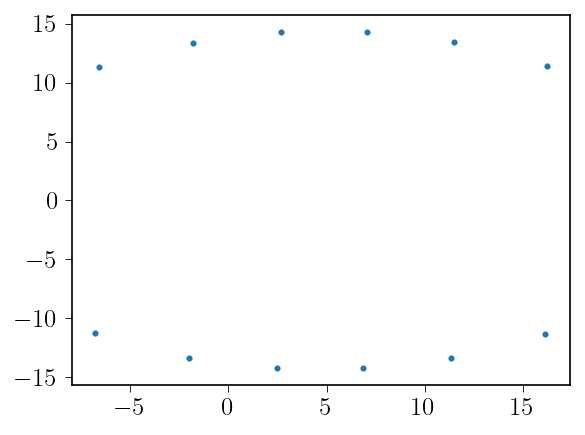

In [40]:
poles = r.poles()
plt.scatter(poles.real, poles.imag)